<a href="https://colab.research.google.com/github/anjanaram1/GenomicConsensus/blob/master/AMIA2018_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation and Interpretability in Deep Learning
## AMIA 2018

Welcome to the AMIA 2018 tutorial on "Evaluation and Interpretability in Deep Learning"!

This notebook will guide you through the interactive session. Feel free to work through at your own pace, and let us know if you have any questions.

## Setup

First we'll need to set up the Colab environment for our exercises.

If you haven't already, click the "Connect" button in the top-right corner.

Then, run the next code segment to import the packages we'll need. (You might have to accept a prompt.)

In [0]:
# set up environment

# for our DNN model
import tensorflow
import keras
import numpy as np

# for setting up our data and evaluating results
from sklearn.datasets import make_classification, make_blobs, make_moons
from sklearn.metrics import precision_recall_fscore_support, \
confusion_matrix, roc_curve, auc, \
precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt

We'll be using a straightforward DNN binary classsification model for our demonstrations, and a toy dataset that we can build using the following functions.

Run the next code block to define the model building and data generation methods.

In [0]:
# Set up our model and a toy dataset to demonstrate
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import SGD
from keras.utils import np_utils


# Data is going to be from the sklearn make_classification function
def get_data(balance=None):
  #X, y = make_moons(n_samples=2000,
  #                 noise=0.2)
  
  X, y = make_classification(n_samples=5000,
                          n_features=50,
                          n_clusters_per_class=2,
                          n_informative=50,
                          n_redundant=0,
                             shuffle=False,
                            weights=balance,
                            flip_y=0.0)
  
  return X, y

# set up our model


def get_model():
  '''
  Define a small, fully-connected network for demonstration purposes
  '''
  model = Sequential()
  model.add(Dense(25, 
                  input_dim=X.shape[1], 
                  kernel_initializer='uniform', 
                  activation='relu'))
  model.add(Dense(2))
  model.add(Activation('softmax'))

  sgd = SGD(lr=0.01)
  model.compile(loss='binary_crossentropy',
               optimizer=sgd,
               metrics=['acc'])
  return model




## Working with Balanced Data

We'll be looking at a binary classification problem for these exercises, where our outputs (y) are either 0 or 1. In the first example, we'll look at balanced data, where the number of examples labeled 0 is the same as the number of examples labeled 1.

The next code block gets our data and plots a histogram of the y values to confirm that they are in fact balanced.

(5000, 50)


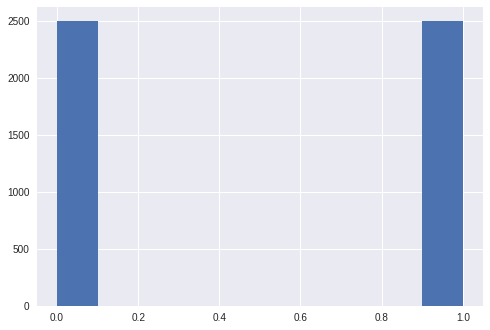

In [8]:
X, y = get_data()

print(X.shape)

plt.figure()
plt.hist(y)
plt.show()

model = get_model()



Once we have our data, we split it into training and testing partitions.

This way, we can have a held-out test set to validate our model with.

In the code below, "stratify" ensures that the label balance is maintained in the training and testing partitions (this will be important later).

Again, we plot a histogram to look at the distribution of labels in the training and testing set.

125000 125000


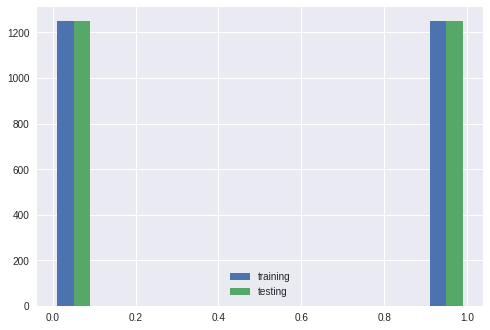

In [9]:
# split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    stratify=y)
print(X_train.size, X_test.size)
plt.figure()
plt.hist([y_train, y_test], label=['training', 'testing'])
plt.legend(loc=0)
plt.show()



In this next block we're going to define a function to handle our model training and evaluation.

It's going to do a lot of the heavy lifting for us in our examples.

First, we train our model (model.fit) and calculate test-set accuracy (model.evaluate)

Since we want to run some more metrics, we also call model.predict to get the outputs of the model so that we can compare them to the true labels.

In [0]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, config):
  '''
  Here we're going to define our model training and evaluation procedure.
  We will:
  1. train our model with X_train and y_train
  2. calculate test metrics with X_test and y_test
  3. Plot our Reciever Operating Characteristic and Average Precision Curves
  '''
  
  print('######### Training the model #########')
  # convert labels to categorical for model
  y_train_cat = np_utils.to_categorical(y_train)
  y_test_cat = np_utils.to_categorical(y_test)
  model.fit(X_train, y_train_cat, 
            epochs=config['epochs'], 
            batch_size=config['batch_size'], 
            verbose=config['verbose']) 
  (loss, acc) = model.evaluate(X_train, y_train_cat, batch_size=32, verbose=config['verbose'])
  print('Loss: {}, accuracy: {}'.format(loss, acc))
  
  print('######### Calculating test set accuracy #########')
  (loss, acc) = model.evaluate(X_test, y_test_cat, batch_size=32, verbose=config['verbose'])
  print('Loss: {}, accuracy: {}'.format(loss, acc))
  preds = model.predict(X_test, 
                        batch_size=config['batch_size'], 
                        verbose=config['verbose'])
  predictions = np.argmax(preds, axis=1)
  
  print('######### Test set confusion matrix #########')
  print(confusion_matrix(y_test, predictions))

  print('######### Precision, recall, and F1 scores #########')
  print(precision_recall_fscore_support(y_test, predictions))

  print('######### Plotting ROC #########')
  # here we can use the p(y=1) values 
  fpr, tpr, _ = roc_curve(y_test, preds[:,1])
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  
  print('######### Plotting precision-recall curve #########')
  average_precision = average_precision_score(y_test, preds[:, 1])
  precision, recall, _ = precision_recall_curve(y_test, preds[:, 1])

  plt.step(recall, precision, color='b', alpha=0.2,
           where='post')
  plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))





Now that we have our functions defined, let's train our model on the data we have.

The config dictionary handles some of the hyperparameters for model training. Feel free to change the batch size and number of epochs for training.

Also, if you change 'verbose' to 1, you'll see per-epoch outputs. This is nice when you want to see how quickly the model training improves.


######### Training the model #########
Loss: 0.061701135855913164, accuracy: 0.9904
######### Calculating test set accuracy #########
Loss: 0.1325478226184845, accuracy: 0.9476
######### Test set confusion matrix #########
[[1175   75]
 [  56 1194]]
######### Precision, recall, and F1 scores #########
(array([0.95450853, 0.94089835]), array([0.94  , 0.9552]), array([0.94719871, 0.94799524]), array([1250, 1250]))
######### Plotting ROC #########


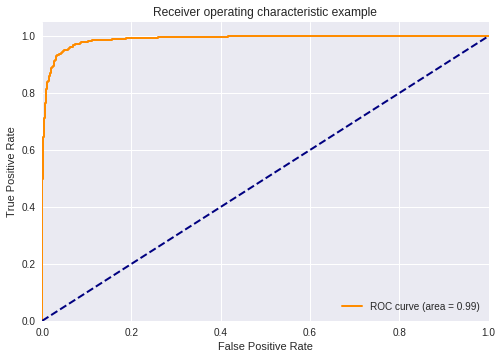

######### Plotting precision-recall curve #########


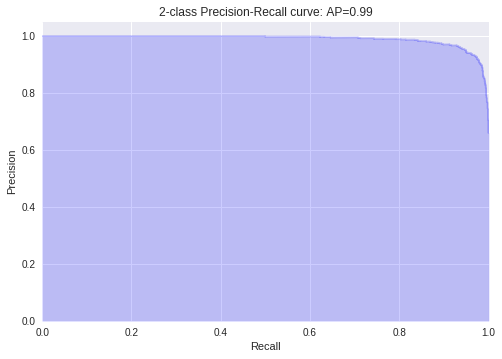

In [12]:
config = {
    'epochs': 50,
    'batch_size': 128,
    'verbose': 0
}

train_and_evaluate(model, X_train, y_train, 
                   X_test, y_test, config)

## Imbalanced Data

In the last section we saw how the model generalizes when dealing with balanced data.

What about imbalanced data? For example, you may want to train a model that detects some rare adverse event in text. It's important to set up your learning problem in such a way that you are prepared for imbalanced data if that is what you expect to see.

First, we'll train a model with imbalanced data with a random training-testing split and look at what happens.

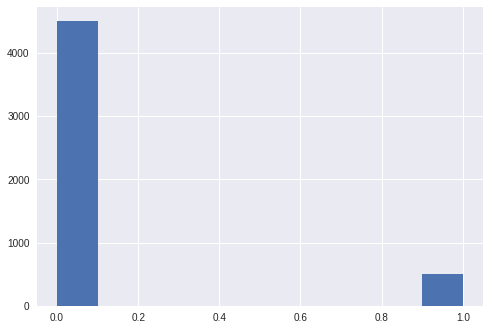

205000 45000


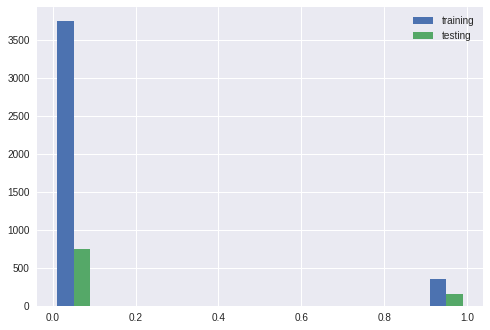

######### Training the model #########
Loss: 0.035898232954304395, accuracy: 0.9921951219512195
######### Calculating test set accuracy #########
Loss: 0.19956182426876493, accuracy: 0.9322222222222222
######### Test set confusion matrix #########
[[747   3]
 [ 58  92]]
######### Precision, recall, and F1 scores #########
(array([0.92795031, 0.96842105]), array([0.996     , 0.61333333]), array([0.9607717 , 0.75102041]), array([750, 150]))
######### Plotting ROC #########


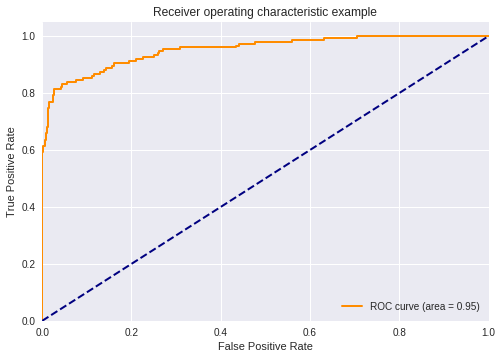

######### Plotting precision-recall curve #########


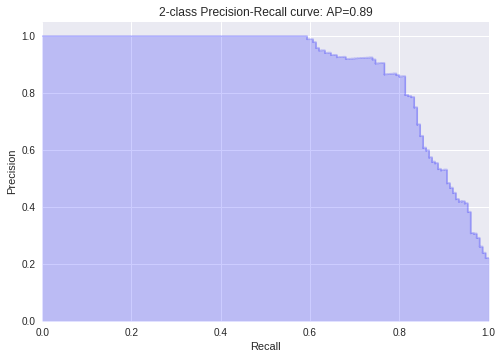

In [13]:
# let's look at imbalanced data where we don't stratify
X, y = get_data(balance=[0.9, 0.1])

plt.figure()
plt.hist(y)
plt.show()

model = get_model()

X_train = np.vstack((X[:4000], X[4900:]))
X_test = X[4000:4900]

y_train = np.hstack((y[:4000],y[4900:]))
y_test = y[4000:4900]

# split the data into training and testing 
#X_train, X_test, y_train, y_test = \
#      train_test_split(X, y, test_size=0.5, 
#                       shuffle=True,
#                       stratify=None,
#                      random_state=42)

print(X_train.size, X_test.size)
plt.figure()
plt.hist([y_train, y_test], label=['training', 'testing'])
plt.legend(loc=0)
plt.show()

config = {
    'epochs': 50,
    'batch_size': 128,
    'verbose': 0
}

train_and_evaluate(model, X_train, y_train, 
                   X_test, y_test, config)



Take a look at the confusion matrix, particularly for the positive examples. The poor performance there pulls down the F1 score, even though accuracy is still high.

In the next block, we'll "stratify" our training and testing split so that the distribution over the labels is consistent between training and testing.

We'll use the same dataset as the last example so we can directly compare the difference.

200000 50000


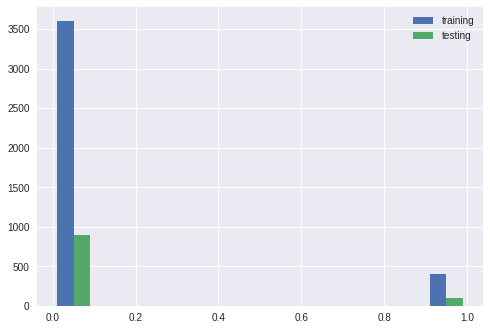

######### Training the model #########
Loss: 0.029029268469661473, accuracy: 0.99375
######### Calculating test set accuracy #########
Loss: 0.05438560852408409, accuracy: 0.98
######### Test set confusion matrix #########
[[896   4]
 [ 16  84]]
######### Precision, recall, and F1 scores #########
(array([0.98245614, 0.95454545]), array([0.99555556, 0.84      ]), array([0.98896247, 0.89361702]), array([900, 100]))
######### Plotting ROC #########


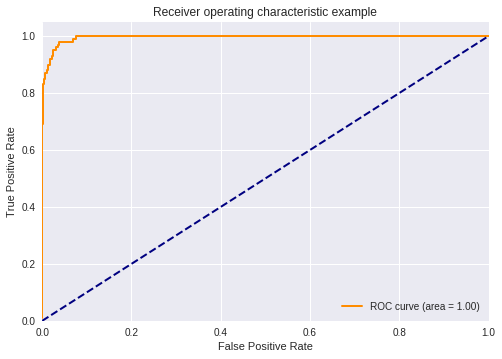

######### Plotting precision-recall curve #########


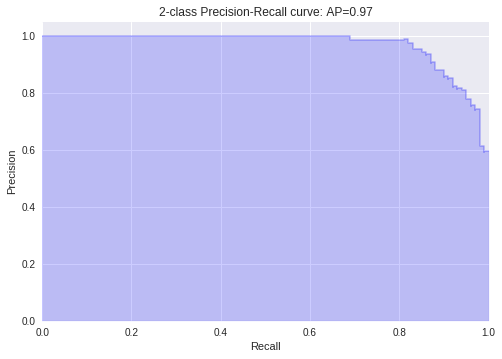

In [14]:
# initialize new model
model = get_model()

# split the data into training and testing 
# note the stratify arg here
X_train, X_test, y_train, y_test = \
      train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

print(X_train.size, X_test.size)
plt.figure()
plt.hist([y_train, y_test], label=['training', 'testing'])
plt.legend(loc=0)
plt.show()

config = {
    'epochs': 50,
    'batch_size': 128,
    'verbose': 0
}

train_and_evaluate(model, X_train, y_train, 
                   X_test, y_test, config)



Because the data is balanced, there are fewer misclassified positive examples, and F1 score for those positive examples is higher.

## Wrapping Up

Feel free to experiment with this code! You can change the model, how the data is generated, etc.

Once you are finished, you can save your copy of the notebook to your Google Drive account by clicking "File" --> "Save a copy in Drive"